### Importation des librairies

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, auc, classification_report, confusion_matrix,
                             f1_score, log_loss, precision_score, recall_score, roc_auc_score, roc_curve)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.discrete.discrete_model import BinaryResultsWrapper
import matplotlib.pyplot as plt

### Importation des données 

In [2]:
df = pd.read_csv("../data/hmeq.csv")

(5960, 11)


In [ ]:
print(df.shape)

In [ ]:
df = df.drop_duplicates() ## suppression des doublons 

* Drop CLNO (variable non significative) et VALUE (variable fortement corrélée avec MORTDUE) 

In [ ]:
df.drop(columns=["CLNO", "VALUE"], inplace=True) 

In [3]:
nb_missing_value = df.isnull().sum(axis=1)
df = df[
            nb_missing_value < 5
        ]
df = df.dropna(subset=["MORTDUE", "DEROG", "DELINQ", "CLAGE", "NINQ"])
print(df.shape)

(4730, 11)


* Split Dataset

In [4]:
X = df.drop(columns=["BAD"])
y = df["BAD"]
X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=42
        )

### Imputation des valeurs manquantes 

In [5]:
def impute_by_value(X_train, X_test, col, value):
    X_train[col] = X_train[col].fillna(value)
    X_test[col] = X_test[col].fillna(value)
    return X_train, X_test

def impute_by_median(X_train, X_test, col):
    X_train[col] = X_train[col].fillna(X_train[col].median())
    X_test[col] = X_test[col].fillna(X_train[col].median())
    return X_train, X_test

In [6]:
X_train, X_test = impute_by_value(X_train, X_test, "JOB", "Manquant") # imputation par manquant les valeurs manquantes de JOB
X_train, X_test = impute_by_value(X_train, X_test, "REASON","Manquant") # imputation par manquant les valeurs manquantes de REASON
X_train, X_test = impute_by_value(X_train, X_test, "YOJ", -1) # imputation par -1 les valeurs manquantes de YOJ (pas d'emploi)
X_train, X_test = impute_by_median(X_train, X_test, "DEBTINC") # imputation par la médiane les valeurs manquantes de DEBTINC 

print(X_train.isnull().sum())

# Supprimer toutes les lignes où on a des valeurs manquantes pour le reste des variables 

X_train.dropna(inplace=True)
X_test.dropna(inplace=True)

y_train = y_train.loc[X_train.index]
y_test = y_test.loc[X_test.index]

LOAN       0
MORTDUE    0
REASON     0
JOB        0
YOJ        0
DEROG      0
DELINQ     0
CLAGE      0
NINQ       0
DEBTINC    0
dtype: int64


### Encodage des variables catégorielles 

* Utilisation du One-Hot-Encoding : Variables REASON et JOB

In [7]:
X_train = pd.get_dummies(X_train, columns=["REASON", "JOB"])
X_test = pd.get_dummies(X_test, columns=["REASON", "JOB"])

X_train.drop(columns=["JOB_Office", "REASON_DebtCon"], inplace=True)
X_test.drop(columns=["JOB_Office", "REASON_DebtCon"], inplace=True)

# il faut s'assurer que les colonnes de X_train et X_test sont identiques
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

### Traitement des outliers 

* Distance de Cook

In [8]:
class SupprimerOutlierAvecCookDistance:
    def __init__(self, donnees: pd.DataFrame, variable_cible: str) -> None:
        self.donnees = donnees
        self.variable_cible = variable_cible
        self.nombre_observations = len(donnees)
        self.nombre_parametres = donnees.shape[1]
        self.colonnes_numeriques = donnees.select_dtypes(
            include=["float64", "int64"]
        ).columns
        self.colonnes_categoriques = donnees.select_dtypes(include=["object"]).columns
        self.donnees_nettoyees = None
        self.nombre_outliers = 0

    def ajuster_modele_logistique(self) -> BinaryResultsWrapper:
        variables_predictives = self.colonnes_numeriques.drop(self.variable_cible)
        X = self.donnees[variables_predictives]
        y = self.donnees[self.variable_cible]

        X_avec_constante = sm.add_constant(X)
        modele_logistique = sm.Logit(y, X_avec_constante)
        return modele_logistique.fit()

    def identifier_outliers(self) -> None:
        ajustement_modele = self.ajuster_modele_logistique()
        influence = ajustement_modele.get_influence()
        distance_cook = influence.cooks_distance[0]
        # quid seuil ? Kenneth A. Bollen, Robert W. Jackman (1990)
        seuil_cook = 4 / (self.nombre_observations - self.nombre_parametres)
        outliers = np.where(distance_cook > seuil_cook)[0]
        outliers_index = self.donnees.index[outliers]
        self.donnees_nettoyees = self.donnees.drop(index=outliers_index)
        self.nombre_outliers = len(outliers)
        return outliers_index

    def obtenir_donnees_sans_outlier(self) -> tuple[pd.DataFrame, int]:
        print(
            "Nombre d'observations avant suppression des outliers: ", len(self.donnees)
        )
        outliers_index = self.identifier_outliers()
        print(
            "Nombre d'observations après suppression des outliers: ",
            len(self.donnees_nettoyees),
        )
        outliers_data = self.donnees.loc[outliers_index, self.variable_cible]
        print("Nombre de targets positives supprimées: ",np.sum(outliers_data == 1))
        return self.donnees_nettoyees, self.nombre_outliers

In [ ]:
X_train_with_target = pd.concat([X_train, y_train], axis=1)

In [9]:
supprimer_outlier = SupprimerOutlierAvecCookDistance(X_train_with_target, 'BAD')
X_train_with_target, nombre_outliers = supprimer_outlier.obtenir_donnees_sans_outlier()
y_train = X_train_with_target["BAD"]
X_train = X_train_with_target.drop(columns=["BAD"])
print(X_train.shape)
print(nombre_outliers)

Nombre d'observations avant suppression des outliers:  3784
Optimization terminated successfully.
         Current function value: 0.387177
         Iterations 7
Nombre d'observations après suppression des outliers:  3511
Nombre de targets positives supprimées:  201
(3511, 16)
273


## Regression Logistique 

**Tableau des coefficients de régression logistique**

In [10]:
cat_col = X_train.select_dtypes(include=["bool"]).columns
X_train[cat_col] = X_train[cat_col].astype(int)
X_test[cat_col] = X_test[cat_col].astype(int)
X_train = sm.add_constant(X_train)
logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.244354
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                    BAD   No. Observations:                 3511
Model:                          Logit   Df Residuals:                     3494
Method:                           MLE   Df Model:                           16
Date:                Fri, 25 Oct 2024   Pseudo R-squ.:                  0.4525
Time:                        15:48:07   Log-Likelihood:                -857.93
converged:                       True   LL-Null:                       -1567.1
Covariance Type:            nonrobust   LLR p-value:                1.888e-292
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -3.2247      0.537     -6.000      0.000      -4.278      -2.171
LOAN          

* Evaluation des performances 

In [11]:
def eval_model(result, X_test, y_test, threshold=0.5):
        X_test = sm.add_constant(X_test)
        print(X_test.shape)
        y_test_pred = result.predict(X_test)
        y_test_pred_bin = (y_test_pred >= threshold).astype(int)
        auc = roc_auc_score(y_test, y_test_pred)
        accuracy = accuracy_score(y_test, y_test_pred_bin)
        f1 = f1_score(y_test, y_test_pred_bin)
        cr = classification_report(y_test, y_test_pred_bin)
        cm = confusion_matrix(y_test, y_test_pred_bin)
        print("AUC: ", auc)
        print("Accuracy: ", accuracy)
        print("F1: ", f1)
        print(cr)
        print(cm)

In [12]:
eval_model(result, X_test, y_test)

(946, 17)
AUC:  0.8301985084448344
Accuracy:  0.8498942917547568
F1:  0.5534591194968553
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       752
           1       0.71      0.45      0.55       194

    accuracy                           0.85       946
   macro avg       0.79      0.70      0.73       946
weighted avg       0.84      0.85      0.84       946

[[716  36]
 [106  88]]


**Courbe Précision-Rappel pour la Régression Logistique**

In [13]:
def cutoffs_graph(result, X_test, y_test):
        recalls = []
        precisions = []
        f1_scores = []
        cutoffs = []
        X_test = sm.add_constant(X_test)
        y_prob = result.predict(X_test)

        for cutoff in np.arange(0, 1, 0.1):
            y_pred = (y_prob >= cutoff).astype(int)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)

            cutoffs.append(cutoff)
            recalls.append(recall)
            precisions.append(precision)
            f1_scores.append(f1)

        plt.figure(figsize=(8, 6))
        plt.plot(cutoffs, recalls, label="recall", color="blue")
        plt.plot(cutoffs, precisions, label="precision", color="green")
        plt.plot(cutoffs, f1_scores, label="f1", color="orange")
        plt.axhline(y=max(f1_scores), color="black", linestyle=":")

        plt.xlabel("Cutoff")
        plt.ylabel("Metrics")
        plt.legend()

        plt.show()

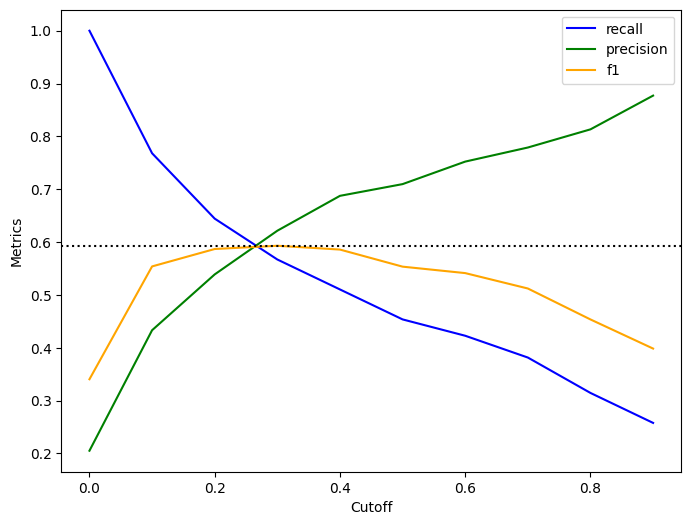

In [14]:
cutoffs_graph(result, X_test, y_test)

In [15]:
eval_model(result, X_test, y_test, 0.3)

(946, 17)
AUC:  0.8301985084448344
Accuracy:  0.8403805496828752
F1:  0.5929919137466307
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       752
           1       0.62      0.57      0.59       194

    accuracy                           0.84       946
   macro avg       0.76      0.74      0.75       946
weighted avg       0.84      0.84      0.84       946

[[685  67]
 [ 84 110]]


(946, 17)


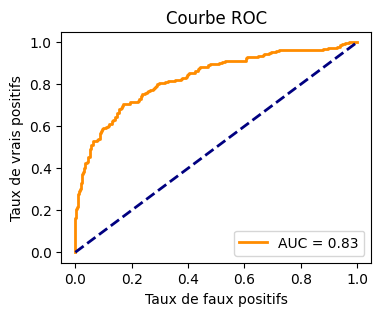

In [16]:
X_test = sm.add_constant(X_test)
print(X_test.shape)
y_prob = result.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()

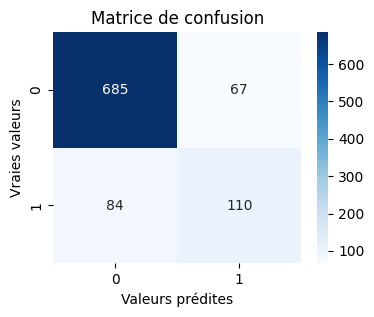

In [17]:
plt.figure(figsize=(4, 3))
y_prob = result.predict(X_test)
y_pred = (y_prob >= 0.3).astype(int)
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Valeurs prédites')
plt.ylabel('Vraies valeurs')
plt.title('Matrice de confusion')
plt.show()

**Importance des caractéristiques dans le modèle de régression logistique**

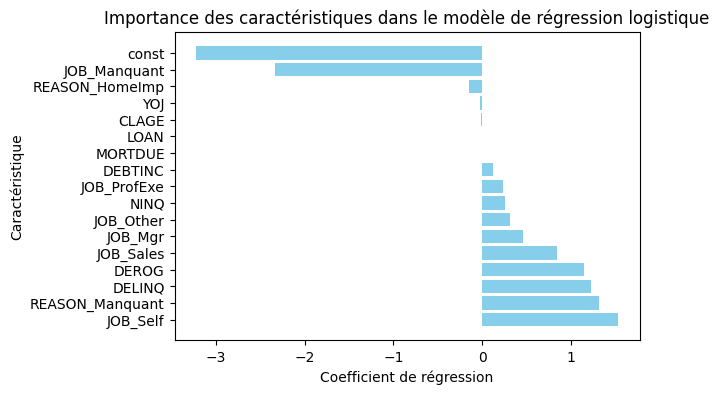

In [18]:
coefficients = result.params
feature_names = X_train.columns

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

feature_importance_df['Abs_Coefficient'] = feature_importance_df['Coefficient']
feature_importance_df = feature_importance_df.sort_values(by='Abs_Coefficient', ascending=False)

plt.figure(figsize=(6, 4))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Abs_Coefficient'], color='skyblue')
plt.xlabel('Coefficient de régression')
plt.ylabel('Caractéristique')
plt.title('Importance des caractéristiques dans le modèle de régression logistique')
plt.show()